## Image Hashing for Similarity Matching

Image Hashing involves modifying an input image to a fixed size binary vector through transformation.

1) Perceptual Hash: Cosine Transformation
2) Difference Hash: Difference between adjacent pixels

Average Hash:

Reduce size. The fastest way to remove high frequencies and detail is to shrink the image. In this case, shrink it to 8x8 so that there are 64 total pixels. Don't bother keeping the aspect ratio, just crush it down to fit an 8x8 square. This way, the hash will match any variation of the image, regardless of scale or aspect ratio.
 
Reduce color. The tiny 8x8 picture is converted to a grayscale. This changes the hash from 64 pixels (64 red, 64 green, and 64 blue) to 64 total colors.
Average the colors. Compute the mean value of the 64 colors.

Compute the bits. This is the fun part. Each bit is simply set based on whether the color value is above or below the mean.

Construct the hash. Set the 64 bits into a 64-bit integer. The order does not matter, just as long as you are consistent.

In [35]:
from PIL import Image
import imagehash
import distance
import scipy.spatial
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np
from scipy.fftpack import dct, idct

In [13]:
img1 = Image.open('/Users/lkshm/Downloads/colorferet/colorferet/dvd2/data/images/01207/01207_940128_hr.ppm/01207_940128_hr.ppm').resize((8,8))
img2 = Image.open('C:/Users/lkshm/Downloads/colorferet/colorferet/dvd2/data/images/01208/01208_940128_fb_a.ppm/01208_940128_fb_a.ppm').resize((8,8))

In [26]:
img1 = np.array(img1)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img2 = np.array(img2)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


### Average Hash

In [27]:
mean2 = img2_gray.mean()
mean1 = img1_gray.mean()


In [28]:
bitsrepr1 = [[1 if i>mean1 else 0 for i in j] for j in img1_gray]
bitsrepr2 = [[1 if i>mean2 else 0 for i in j] for j in img2_gray]


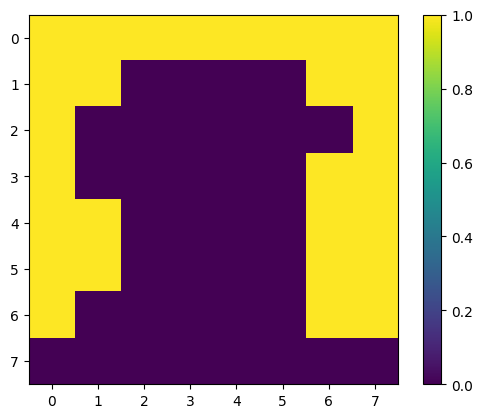

In [29]:
plt.imshow(bitsrepr1, interpolation="nearest", origin="upper")
plt.colorbar()
plt.show()

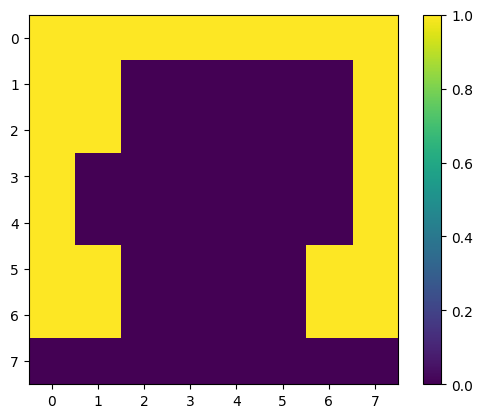

In [30]:
plt.imshow(bitsrepr2, interpolation="nearest", origin="upper")
plt.colorbar()
plt.show()

In [31]:
bitsrepr2 = np.array(bitsrepr2)
bitsrepr1 = np.array(bitsrepr1)
imgHash1 = bitsrepr1.flatten()
imgHash2 = bitsrepr2.flatten()


In [32]:
imgHash1 = int(''.join(map(str, imgHash1)), 2)
imgHash2 = int(''.join(map(str, imgHash2)), 2)


In [33]:
print(imgHash2, imgHash1)

18429223912148812544 18429716503055270656


### pHash

Reduce size. Like Average Hash, pHash starts with a small image. However, the image is larger than 8x8; 32x32 is a good size. This is really done to simplify the DCT computation and not because it is needed to reduce the high frequencies.

Reduce color. The image is reduced to a grayscale just to further simplify the number of computations.

Compute the DCT. The DCT separates the image into a collection of frequencies and scalars. While JPEG uses an 8x8 DCT, this algorithm uses a 32x32 DCT.
Reduce the DCT. While the DCT is 32x32, just keep the top-left 8x8. Those represent the lowest frequencies in the picture.

Compute the average value. Like the Average Hash, compute the mean DCT value (using only the 8x8 DCT low-frequency values and excluding the first term since the DC coefficient can be significantly different from the other values and will throw off the average). Thanks to David Starkweather for the added information about pHash. He wrote: "the dct hash is based on the low 2D DCT coefficients starting at the second from lowest, leaving out the first DC term. This excludes completely flat image information (i.e. solid colors) from being included in the hash description."

Further reduce the DCT. This is the magic step. Set the 64 hash bits to 0 or 1 depending on whether each of the 64 DCT values is above or below the average value. The result doesn't tell us the actual low frequencies; it just tells us the very-rough relative scale of the frequencies to the mean. The result will not vary as long as the overall structure of the image remains the same; this can survive gamma and color histogram adjustments without a problem.

Construct the hash. Set the 64 bits into a 64-bit integer. The order does not matter, just as long as you are consistent.

In [50]:
img1 = Image.open('/Users/lkshm/Downloads/colorferet/colorferet/dvd2/data/images/01207/01207_940128_hr.ppm/01207_940128_hr.ppm').resize((32,32))
img2 = Image.open('C:/Users/lkshm/Downloads/colorferet/colorferet/dvd2/data/images/01208/01208_940128_fb_a.ppm/01208_940128_fb_a.ppm').resize((32,32))

In [51]:
img1 = np.array(img1)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img2 = np.array(img2)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


In [52]:
real1 = np.real(dct(img1_gray))
real2 = np.real(dct(img2_gray))


In [53]:
meanReal1 = real1.mean()
meanReal2 = real2.mean()

In [54]:
bitsrepr1 = [[1 if i>meanReal1 else 0 for i in j[:8]] for j in real1[:8]]
bitsrepr2 = [[1 if i>meanReal2 else 0 for i in j[:8]] for j in real2[:8]]


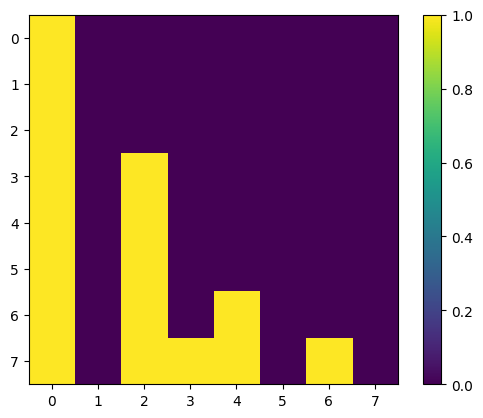

In [55]:
plt.imshow(bitsrepr1, interpolation="nearest", origin="upper")
plt.colorbar()
plt.show()

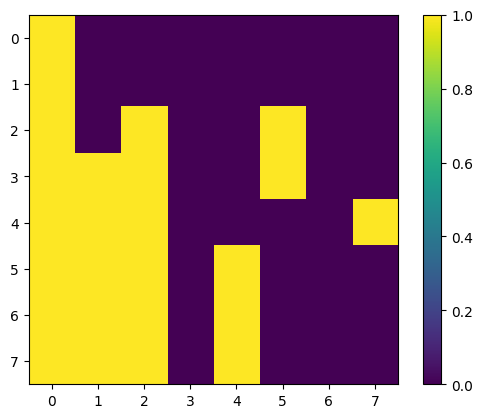

In [56]:
plt.imshow(bitsrepr2, interpolation="nearest", origin="upper")
plt.colorbar()
plt.show()

In [57]:
bitsrepr2 = np.array(bitsrepr2)
bitsrepr1 = np.array(bitsrepr1)
imgHash1 = bitsrepr1.flatten()
imgHash2 = bitsrepr2.flatten()

imgHash1 = int(''.join(map(str, imgHash1)), 2)
imgHash2 = int(''.join(map(str, imgHash2)), 2)

print(imgHash2, imgHash1)

9259582136823376104 9259542261251745978
